# Content Mining Models

## Table of Contents
[1. Data Preprocessing and Imports](#preprocessing) <br>
    [1.1. Provisory recipe filter/sampler ](#sampling) <br>
    [1.2. Keyword extraction and ingredient preprocessing](#keywords) <br>
    [1.3. Creating user-activity data & filtered interactions data](#user-interaction) <br>
    [1.4. NLP Preprocessing](#nlp-preprocessing) <br>
[2. Models](#models) <br>
    [2.0. General functions](#general-functions) <br>
        [2.0.1. Recommendations functions for Coverage & Personalization](#recommendation-functions) <br>
        [2.0.2. Prediction function for RMSE](#prediction-functions) <br>
    [2.1. Cosine Similarity](#cosine) <br>
        [2.1.1 Tfidf & SVD](#tfidf-svd) <br>
        [2.1.2 WordEmbeddings](#word-embeddings) <br>
    [2.2. Mixture Model](#mixture) <br>
        [2.2.1. Make recommendations based on Mixture Model](#mixture-recommendations) <br>
        [2.2.2. Make predictions based on Mixture Model](#mixture-predictions) <br>
        [2.2.3. Optimize lambda parameter](#optimize-lambda) <br>
[3. Interpretation and Evaluation](#interpretation_evaluation) <br>

<a id='preprocessing'></a>
## 1. Data Preprocessing and Imports

##### Packages to install in cmd upfront:

conda install -c conda-forge selenium <br>
conda install -c anaconda nltk <br>
conda install -c conda-forge progressbar <br>
pip install rake-nltk


In [1]:
import pandas as pd
import numpy as np
import nltk
import inflect
import datetime
import re, string, unicodedata
import progressbar
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.metrics import jaccard_score, pairwise_distances_chunked, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from IPython.display import HTML
from datetime import datetime
from progressbar import ProgressBar

In [8]:
# Import functions module
%run functions.py

In [9]:
#load data
interactions_raw = pd.read_csv(
        './Data/RAW_interactions.csv')
recipes_raw = pd.read_csv(
        './Data/RAW_recipes.csv', parse_dates=['submitted'], infer_datetime_format=True)

In [86]:
#make copies so that we don't have to reload the data after mistakes
interactions_data = interactions_raw.copy()
recipes_data = recipes_raw.copy()

In [87]:

recipes_data.rename(columns={"id": "recipe_id"}, inplace=True)


In [88]:
deal_with_NAs(recipes_data)

<a id='sampling'></a>
### 1.1. Provisory recipe filter/sampler 

In [89]:
#create an age column for the recipes
recipes_data['age'] = round((2019-recipes_data.submitted.dt.year)+recipes_data.submitted.dt.month/12, 1)

In [90]:
recipes_data = get_avg_recipe_rating(interactions_data, recipes_data)
filter_byinteractions(10,10,recipes_data, older=True)
filter_byinteractions(5,10,recipes_data, older=False)
filter_byquality(recipes_data)
remove_duplicates(recipes_data)
recipes_data = generate_URL(recipes_data)

Shape after filtering recipes with less than 10 interactions and older than 10 years old: (48605, 15)
Shape after filtering recipes with less than 5 interactions and younger than 10 years old: (20487, 15)
Shape after removing 1 step recipes w/ low interactions: (20487, 15)
Shape after removing recipes w/o ratings: (20487, 15)
Shape after removing 0 minutes interaction w/ low interactions: (20397, 15)
Shape after dropping duplicates: (20371, 15)
URLs created for each of the 20371 recipes


In [50]:
recipes_data.shape

(20371, 16)

<a id='keywords'></a>
### 1.2. Keyword extraction and ingredient preprocessing

In [11]:
# Preprocess ingredients and save as String
for index, row in recipes_data.iterrows():
    ingredientlist = row['ingredients']
    ingredientlist = row['ingredients'].replace('[', '').replace(', ', '').replace(']', '').replace('and', '\'').split("\'")
    ingredientlist = list(filter(None, ingredientlist))
    ingredientlistString = ""
    for i in ingredientlist:
        ingredientlistString = ingredientlistString + i
    recipes_data.at[index, 'ingredients'] = ingredientlistString

In [12]:
# Extract keywords for free text features
# recipes_data = get_keywords(recipes_data, "steps", "steps_keywords")
# recipes_data = get_keywords(recipes_data, "description", "description_keywords")
# interactions_data = get_keywords(interactions_data, "review", "review_keywords")

In [13]:
recipes_data.head(3)

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,age,num_interactions,avg_rating,URL
15,chicken lickin good pork chops,63986,500,14664,2003-06-06,"['weeknight', 'time-to-make', 'course', 'main-...","[105.7, 8.0, 0.0, 26.0, 5.0, 4.0, 3.0]",5,"['dredge pork chops in mixture of flour , salt...",here's and old standby i enjoy from time to ti...,lean pork chopsfloursaltdry mustardgarlic powd...,7,16.5,19,4.88,https://www.food.com/recipe/chicken-lickin-goo...
36,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...",frozen chopped spinacheggsaltblack pepperonion...,8,17.3,113,4.34,https://www.food.com/recipe/how-i-got-my-famil...
43,immoral sandwich filling loose meat,58224,35,37183,2003-04-04,"['60-minutes-or-less', 'time-to-make', 'course...","[223.2, 22.0, 4.0, 7.0, 35.0, 30.0, 0.0]",6,"['brown the meat & drain fat', 'stir in sugar ...",just the thing for a day when you're wanton so...,ground beefsugarprepared yellow mustardbeercay...,8,16.3,21,4.20,https://www.food.com/recipe/immoral-sandwich-f...


<a id='user-interaction'></a>
### 1.3. Creating user-activity data & filtered interactions data

Filter data flow:

filter_interactions_data() -(calls)-> 
    (impute_average_rating(), (create_activity_data() 
                                        -(calls)-> get_user_activity_df())

In [112]:
def impute_average_rating(row, df_uactivity):
    if (row['rating'] == 0):
        imputed_rating = round(df_uactivity.loc[df_uactivity.user_id == row.user_id, 'uavg_rating'].values[0], 0)
        return imputed_rating
    else:
        return row.rating
    
def get_user_activity_df(interactions):
    #Create a user activity dataframe
    df_uactivity = interactions.groupby('user_id')['rating'].value_counts().unstack().fillna(0)
    cols = list(df_uactivity)
    df_uactivity['total_interactions'] = df_uactivity[cols].sum(axis=1)
    df_uactivity['total_ratings'] = df_uactivity['total_interactions']-df_uactivity[0]
    return df_uactivity

def get_user_behavior(filtered_user_activity):
    #calculate arithmetic mean of ratings for each user
    filtered_user_activity['uavg_rating'] = filtered_user_activity.iloc[:,1:6].apply(
        lambda row: np.round(np.ma.average(list(range(1,6)), 
                                           weights = (row[1], row[2], row[3], row[4], row[5])),1), axis = 1)
    filtered_user_activity = filtered_user_activity.reset_index()
    filtered_user_activity.columns.set_names(None, inplace = True)
    return filtered_user_activity
    
def filter_users(interactions_df, thresh_high, thresh_low):
    df_uactivity = get_user_activity_df(interactions_df[['recipe_id','user_id', 'rating']])
    filtered_user_activity = df_uactivity.loc[(df_uactivity['total_interactions']>=thresh_low) &
                                              (df_uactivity['total_interactions']<thresh_high), :]
    
    print(f'Number of users after filtering out users with less than {thresh_low} interactions: {len(filtered_user_activity)}')
    
    #drop users that only have only reviews but no ratings
    filtered_user_activity.drop(filtered_user_activity[filtered_user_activity.total_ratings == 0].index, 
                                inplace=True, 
                                axis=0)
    
    #create average user ratings as behavior
    filtered_user_activity = get_user_behavior(filtered_user_activity)
    
    return filtered_user_activity

def filter_interactions_data(interactions_df, recipes_data, thresh_high, thresh_low):
    
    # 2. Filter interactions with active recipes -> Only interactions from active users and clean recipes remain
    interactions = interactions_df[interactions_df.recipe_id.isin(recipes_data.recipe_id)]
    
    filtered_user_activity = filter_users(interactions, thresh_high, thresh_low)
    # 1. Get user ids of active
    #uids = filtered_user_activity.user_id.drop_duplicates().values
    interactions = pd.merge(filtered_user_activity[['user_id', 'uavg_rating', 'total_interactions']], 
                                        interactions[['recipe_id','user_id', 'rating']], 
                                        how = 'left', on ='user_id')
    
    #interactions_data[interactions_data.user_id.isin(uids)]
    
#     pd.merge(recipes_data[['recipe_id']], 
#                             active_user_interactions[['recipe_id', 'user_id', 'rating', 'uavg_rating', 'total_interactions']], 
#                             on = 'recipe_id', 
#                             how ='left')
    #impute ratings for interactions without ratings
    zero_ratings = len(interactions.loc[interactions.rating==0])
    interactions['rating'] = interactions.apply(lambda row: impute_average_rating(row, filtered_user_activity), axis=1)
    print(f'Number of imputed ratings: {zero_ratings}')

    return interactions[['user_id','recipe_id','rating','uavg_rating', 'total_interactions',]], filtered_user_activity

In [113]:
#filter interactions data such that only interaction with active users 
# and with recipes that were not filtered out before remain
interactions, activity = filter_interactions_data(interactions_data, recipes_data, thresh_high=100, thresh_low=7)
display(interactions.head())
print(interactions.shape)

Number of users after filtering out users with less than 7 interactions: 10824


C:\Users\LiY140\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Number of imputed ratings: 6444


,user_id,recipe_id,rating,uavg_rating,total_interactions
0,1533,96621,5.0,4.8,32.0
1,1533,2137,5.0,4.8,32.0
2,1533,132916,5.0,4.8,32.0
3,1533,13813,5.0,4.8,32.0
4,1533,57549,5.0,4.8,32.0


(222018, 5)


count    10818.000000
mean        19.927343
std         17.575824
min          1.000000
25%          9.000000
50%         13.000000
75%         23.000000
max         99.000000
Name: total_ratings, dtype: float64


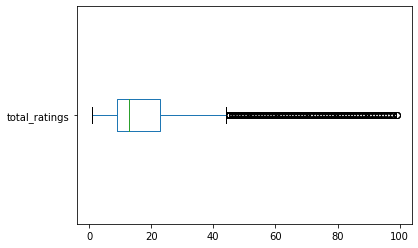

In [114]:
activity['total_ratings'].plot(kind='box', vert=False)
print(activity.total_ratings.describe())

Percent of 5 star rating interactions: 79.31%
Percent of 4 star rating interactions: 15.25%
Percent of 3 star rating interactions: 3.59%
Percent of 2 star rating interactions: 1.25%
Percent of 1 star rating interactions: 0.61%


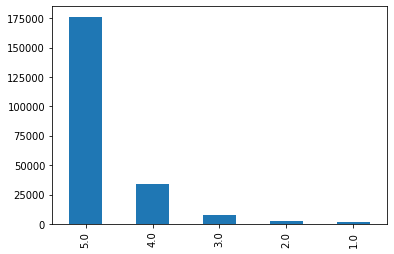

In [115]:
#Let's look at the distribution of ratings
get_rating_dist(interactions.rating)

<a id='nlp-preprocessing'></a>
### 1.4. NLP Preprocessing for recipe data

In [144]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LiY140\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LiY140\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LiY140\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [178]:
def create_input (df, column_names):
    df_content = df
    df_content = df_content.assign(content= df.loc[:, (column_names)].apply(lambda texts: ' '.join(texts), axis=1))
    df_content = df_content.drop(columns = column_names)
    df_content['content']=df_content['content'].apply(lambda text: ' '.join(text.split()))
    return df_content

In [183]:
#checking if all recipes are in interactions
helper = pd.unique(interactions_data['recipe_id'])
df_rfiltered = recipes_data[recipes_data.recipe_id.isin(helper)]
df_rfiltered.shape

(20371, 16)

In [184]:
#flatten steps data
df_rfiltered.steps = df_rfiltered.loc[:, ('steps')].str.replace("\[", "").str.replace("'", "").str.replace("\]", "").str.replace(",","").copy()

#create content df
df_rfiltered = create_input(df_rfiltered[['recipe_id', 'name', 'description', 'steps']], ['name', 'description', 'steps'])

df_rfiltered.head()

,recipe_id,content
15,63986,chicken lickin good pork chops here's and old ...
17,23933,"chinese candy a little different, and oh so go..."
33,54100,grilled venison burgers delicious venison burg...
34,67664,healthy for them yogurt popsicles my children ...
36,25775,how i got my family to eat spinach spinach cas...


In [185]:
#now process content
content_processed = get_processed(df_rfiltered)
content_processed.shape

(20371, 2)

## Split data for evaluation

In [104]:
interactions.shape

(199380, 5)

In [138]:
#Create train-test split of interaction data 
train_split, test_split = get_fixedN_test_train_split(interactions, 3)

C:\Users\LiY140\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [141]:
(len(test_split)/len(train_split))*100

17.120339304931317

Percent of 5 star rating interactions: 79.86%
Percent of 4 star rating interactions: 14.54%
Percent of 3 star rating interactions: 3.48%
Percent of 2 star rating interactions: 1.41%
Percent of 1 star rating interactions: 0.7%


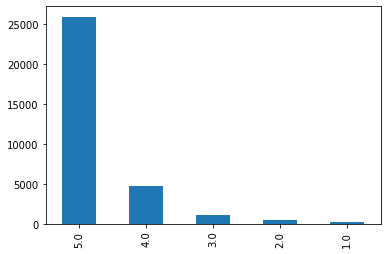

In [140]:
get_rating_dist(test_split.rating)

Percent of 5 star rating interactions: 79.21%
Percent of 4 star rating interactions: 15.37%
Percent of 3 star rating interactions: 3.6%
Percent of 2 star rating interactions: 1.22%
Percent of 1 star rating interactions: 0.59%


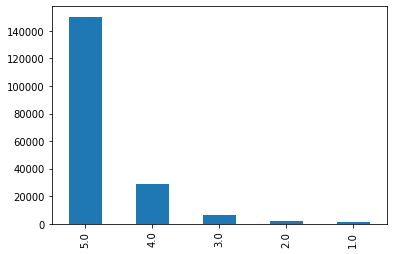

In [143]:
get_rating_dist(train_split.rating)

In [137]:
def get_fixedN_test_train_split(interactions, n):
    """
    Parameters
    ---------
    
    Returns
    ---------
    test_split: DataFrame
        Interactions DataFrame containing only n interactions per user
    train_split: DataFrame
        Interactions DataFrame containing the rest of the interactions
    """
    
    test_split = pd.DataFrame(columns = ['user_id', 'recipe_id', 'rating'])
    groups = interactions.groupby('user_id')
    
    #with progressbar.ProgressBar(max_value=len(interactions.user_id.drop_duplicates().values)) as bar:
    for i, group in groups:
        test_shard = group.sample(n=n, random_state=10)
        test_split = pd.concat([test_split, test_shard], ignore_index=True)
            
    interactions = interactions.set_index(['user_id', 'recipe_id']).sort_index()    
    test_split = test_split.set_index(['user_id', 'recipe_id']).sort_index()
    train_split = interactions[~interactions.index.isin(test_split.index)]
    
    return train_split, test_split

## Metrics functions

In [201]:
def get_relevant_recipes(uid):
    """
    Parameters:
    --------
    uid: 
    user id to fetch relevant recipes for
    
    Returns
    --------
    relevant_recipes: array
    list of recipes the user has rated higher than 4
    """
    user_interactions = interactions.loc[interactions['user_id']==uid, ['recipe_id', 'rating']]
    relevant_recipes = user_interactions.loc[user_interactions.rating >= 4.0, 'recipe_id'].values
    non_relevant_recipes = user_interactions.loc[user_interactions.rating < 4.0, 'recipe_id'].values
    return relevant_recipes

def get_hits(rec_dict):
    
    hits_total = [,,,,]
    #loop over dict
    
    #for uid in rect_dict:
        #get_relevant_recipes()
        #hits = compare recs with relevant
        # append(len(hits))
    
    return hits

def get_avg_precision(hits_total, k):
    
    return avg_precision

def get_avg_recall(hits_total, n):
    
    return avg_recall

def get_f_one(precision, recall):
    
    return f_one

def catalog_coverage(rec_dict, num_total_recipes):
    #unique_recs = set union over all recommendations
    #catalog_coverage = unique_recs
    
    return catalog_coverage

def get_hits_old(uid, similarity, content, interactions, k):
    """
    returns whether a recommendation was relevant or not
    A recommendation is judged as relevant if it is part of the past ratings of the user and has been rated higher than 4.0
    Parameters
    ---------
    recommendations: array
    list of topk recipe ids for 1 user
    
    relevant_recipes: array
    list of recipes the user has rated higher than 4
    
    Returns
    ---------
    
    """  
    topk_recipes = pd.Series(get_topk_recipes_lean(uid, similarity, content, interactions, k))
    
    relevant_recipes = get_relevant_recipes(uid)
    
    hits = topk_recipes[topk_recipes.isin(relevant_recipes)]
    
    return hits

def get_precision_old(uids, similarity, content, interactions, k):  
    pbar = ProgressBar()
    precision=[]
    
    for i in pbar(range(len(uids))):
        hits = get_hits(uids[i], similarity, content, interactions, k)
        prec = len(hits)/k
        precision.append(prec)
        
    return precision

In [196]:
p = get_precision(interactions.user_id.drop_duplicates().values, cosine_sim, content_processed, interactions, 7)

100% (16895 of 16895) |##################| Elapsed Time: 0:09:16 Time:  0:09:16


In [209]:
hitrate = sum(i > 0 for i in p)/len(p)
hitrate

0.013080793134063332

In [210]:
average_precision = (sum(p)/len(p))*100

In [187]:
get_topk_recipes_lean(4470, cosine_sim, content_processed, interactions, 7)

array([305776,  94164, 220846, 160432, 307882, 364964,  61591],
      dtype=int64)

<a id='models'></a>
## 2. Models

<a id='general-functions'></a>
### 2.0 General functions

<a id='recommendation-functions'></a>
#### 2.0.1 Recommendations functions for precision

In [191]:
#return top k predicted ratings in readable form 

# IMPORTANT: must set the dataframe for recipe_info index == recipe_id!
def get_user_recommendations(user_id, similarity, content, interactions, recipe_info, k):
    """
     Returns
    ----------
    info:
        HTML dataframe with recommendation information
    """
    #get top k recipe ids
    topk_recipes, predictions, recipeurls, imageurls = get_topk_recipes(user_id, similarity, content, interactions, k)
    info = recipe_info.loc[topk_recipes]
    info = info[['name', 'minutes', 'submitted', 'description']]
    info['prediction'] = predictions
    info['recipeurl'] = recipeurls
    info['imageurl'] = imageurls
    for index, row in info.iterrows():
        info.at[index, 'recipeurl'] = '<a href="'+ row['recipeurl'] + '">'+row['recipeurl'] +'</a>'
        info.at[index, 'imageurl'] = '<a href="'+ row['imageurl'] + '"> Image of recipe '+str(index)+'</a>'
    info = HTML(info.to_html(escape=False))
    return info

def get_topk_recipes(user_id, similarity, content, interactions, k):
    """
     Returns
    ----------
    topk_recipes:
        array of top k recipe ids
    predictions:
        array with top k predictions
    recipeurls:
        array with top k recipe urls
    imageurls:
        array with top k recipe imageurls
    """
    prediction_df = get_user_preference(user_id,similarity, content, interactions)
    #take only the not yet seen recipes
    #new_predictions = prediction_df[prediction_df['has_rated'] == False]
    #sort predictions
    ordered_predictions = new_predictions.sort_values(by='prediction', ascending=False)
    #get recipe_id array
    topk_recipes = ordered_predictions.index[:k].values
    imageurls = []
    recipeurls = []
    for entry in topk_recipes:
        recipeurls.append("https://www.food.com/recipe/" + str(entry))
        imageurls.append(get_image_source_url(entry))
    predictions = ordered_predictions.prediction[:k].values
    return topk_recipes, predictions, recipeurls, imageurls

#return predictions for 1 user
def get_user_preference(user_id, similarity, content, interactions_data):
    """
     Returns
    ----------
    prediction_df:
        DataFrame in with columns ['recipe_id','prediction', 'has_rated'] for 1 user
    """
    #prepare similarity dataframe
    sim = pd.DataFrame(similarity, index=content['recipe_id'].values, columns=content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions_data.loc[interactions_data['user_id']==user_id, 'recipe_id'].values
    #get similarities of ALL recipes w/ already rated recipes of user
    sim_rated_all = sim.loc[rated_recipes, :]
    #get ratings of already rated recipes
    ratings = get_reshaped_ratings(user_id, interactions_data)
    
    #compute weighted similarities between all recipes and already rated recipes
    weighted_sim = np.dot(ratings,sim_rated_all)
    #compute normalization constant
    norm_const = np.array(np.abs(sim_rated_all).sum(axis=0))
    #return sorted predictions
    pref_predictions = weighted_sim/norm_const
    
    flat_predictions = [item for sublist in pref_predictions for item in sublist]
    #return df with recipe id also
    prediction_df = pd.DataFrame(flat_predictions, index=content['recipe_id'].values, columns =['prediction'])
    #indicate the already tried recipes
    prediction_df['has_rated'] = prediction_df.index.isin(rated_recipes)
    #order predictions
    return prediction_df

#arrange ratings for matrix multiplication
def get_reshaped_ratings(user_id, interactions_data):
    ratings = interactions_data.loc[interactions_data['user_id']==user_id, :]
    ratings.set_index('recipe_id', inplace=True)
    ratings.index.set_names(None, inplace = True)
    ratings = ratings.drop(columns='user_id')
    ratings = ratings.transpose()
    ratings.rename(index={'rating':user_id}, inplace=True)
    return ratings.loc[ratings.index==user_id]

In [192]:
def make_all_recommendations(user_ids, similarity, content, interactions, k):
    """
    Params
    --------
    user_ids: Array
        list of user ids
    similarity: Array 
        similarity matrix with shape (#recipes, #recipes).
    content: DataFrame
        processed DataFrame with ['recipe_id', 'content'] used to fetch all recipes ids to make recommendations for 
        (=total training data)
    interactions: DataFrame
        preprocessed interactions DataFrame ['recipe_id', 'user_id', 'rating']     
    k: integer
        number of recommendations to make
    Returns:
    --------
    nested_recommendations:
        nested list of recommended recipe_ids for each user in param list
        example:[[rid1, rid20, rid30...], [rid1, rid20, rid30...],[rid1, rid20, rid30...]]
    """
    pbar = ProgressBar()
    nested_recommendations={}
    for i in pbar(range(len(user_ids))):
        recs = get_topk_recipes_lean(user_ids[i], similarity, content, interactions, k)
        nested_recommendations[user_ids[i]]:recs
    return nested_recommendations

def get_topk_recipes_lean(user_id, similarity, content, interactions, k):
    """
     Returns
    ----------
    topk_recipes:
        array of top k recipe ids
    predictions:
        array with top k predictions
    recipeurls:
        array with top k recipe urls
    imageurls:
        array with top k recipe imageurls
    """
    prediction_df = get_user_preference(user_id, similarity, content, interactions)
    #sort predictions
    ordered_predictions = prediction_df.sort_values(by='prediction', ascending=False)
    #get recipe_id array
    topk_recipes = ordered_predictions.index[:k].values
    predictions = ordered_predictions.prediction[:k].values
    return topk_recipes

In [24]:
#Source: https://github.com/statisticianinstilettos/recmetrics/
import random
import scipy.sparse as sp

# # input = nested_recommendations from make_all_recommendations
# def catalog_coverage(predicted, catalog, k):
#     """
#     Computes the catalog coverage for k lists of recommendations
#     Parameters
#     ----------
#     predicted : a list of lists
#         Ordered predictions
#         example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
#     catalog: list
#         A list of all unique items in the training data
#         example: ['A', 'B', 'C', 'X', 'Y', Z]
#     k: integer
#         The number of observed recommendation lists
#         which randomly choosed in our offline setup
#     Returns
#     ----------
#     catalog_coverage:
#         The catalog coverage of the recommendations as a percent
#         rounded to 2 decimal places
#     ----------    
#     Metric Defintion:
#     Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
#     Beyond accuracy: evaluating recommender systems by coverage and serendipity.
#     In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
#     """
#     sampling = random.choices(predicted, k=k)
#     predicted_flattened = [p for sublist in sampling for p in sublist]
#     L_predictions = len(set(predicted_flattened))
#     catalog_coverage = round(L_predictions/(len(catalog)*1.0)*100,2)
#     return catalog_coverage

# def personalization(predicted):
#     """
#     Personalization measures recommendation similarity across users.
#     A high score indicates good personalization (user's lists of recommendations are different).
#     A low score indicates poor personalization (user's lists of recommendations are very similar).
#     A model is "personalizing" well if the set of recommendations for each user is different.
#     Parameters:
#     ----------
#     predicted : a list of lists
#         Ordered predictions
#         example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
#     Returns:
#     -------
#         The personalization score for all recommendations.
#     """

#     def make_rec_matrix(predicted):
#         df = pd.DataFrame(data=predicted).reset_index().melt(
#             id_vars='index', value_name='item',
#         )
#         df = df[['index', 'item']].pivot(index='index', columns='item', values='item')
#         df = pd.notna(df)*1
#         rec_matrix = sp.csr_matrix(df.values)
#         return rec_matrix

#     #create matrix for recommendations
#     predicted = np.array(predicted)
#     rec_matrix_sparse = make_rec_matrix(predicted)

#     #calculate similarity for every user's recommendation list
#     similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)

#     #get indicies for upper right triangle w/o diagonal
#     upper_right = np.triu_indices(similarity.shape[0], k=1)

#     #calculate average similarity
#     personalization = np.mean(similarity[upper_right])
#     return 1-personalization

<a id='prediction-functions'></a>
#### 2.0.2 Prediction function for RMSE

In [189]:
#prediction for 1 already rated recipe based on similarities to other already rated recipes

def get_one_prediction(similarity, content, interactions, user_id, recipe_id):
    sim = pd.DataFrame(similarity, index=content['recipe_id'].values, columns=content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions[interactions['user_id']==user_id]['recipe_id'].values
    #get similarities of to be predicted recipe rating with already rated recipes by user x
    sim_rated = sim.loc[sim.index==recipe_id, rated_recipes].loc[recipe_id].values
    #get ratings of rated recipes
    ratings = interactions[interactions['user_id']==user_id]['rating'].values
    
    actual = interactions.loc[(interactions.user_id==user_id) & (interactions.recipe_id==recipe_id)]['rating'].values[0]
    prediction = np.dot(ratings, sim_rated) /np.array([np.abs(sim_rated).sum(axis=0)])
    return actual, prediction

In [193]:
def make_all_predictions(num_interactions, similarity, content, interactions, uid_array, rids_array):
    predictions_cos = []
    actual_cos = []
    pbar = ProgressBar()
    
    for i in pbar(range(num_interactions)):
        act, pred = get_one_prediction(similarity, content, interactions, uid_array[i], rids_array[i])
        predictions_cos.append(pred)
        actual_cos.append(act)
        
    return predictions_cos, actual_cos


In [27]:
#only relevant if there is a recipe sample

# def get_interaction_processed(processed, interactions):
#     #fetch only interactions in the preprocessed sample
#     interactions_processed = interactions.loc[interactions.recipe_id.isin(processed.recipe_id)]\
#                            .reset_index()\
#                            .drop(columns=['index'])
#     print(f'Interactions before processing: {len(interactions.index)}\nInteractions covered in sample: {len(interactions_processed.index)}')
#     return interactions_processed

<a id='cosine'></a>
### 2.1. Cosine similarity

<a id='tfidf-svd'></a>
#### 2.1.1 Tfidf & SVD

In [194]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [195]:
def get_cos_sim_matrix(processed, n_components):
    tfidf = TfidfVectorizer(stop_words='english')
    processed['content'] = processed['content'].fillna('')
    tfidf_matrix = tfidf.fit_transform(processed['content'])
    #reduce dimensionality of tfidf matrix
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    tfidf_truncated = svd.fit_transform(tfidf_matrix) 
    cosine_sim = cosine_similarity(tfidf_truncated,tfidf_truncated)
    return cosine_sim

In [41]:
cosine_sim = get_cos_sim_matrix(content_processed, 10)
cosine_sim.shape

(11090, 11090)

#### 2.1.1.3 Optimize n_components of tfidf/SVD

In [198]:
def tuning_cos_rmse(n_components, content, interactions, uid_array, rids_array):
    rmse_cos = []
    
    for n in n_components:
        print("Computing predictions & recommendations for:", n)
        similarity = get_cos_sim_matrix(content, n)
        
        predictions, actuals = make_all_predictions(len(interactions), 
                                                    similarity, 
                                                    content, 
                                                    interactions, 
                                                    uid_array, 
                                                    rids_array)
        rmse = mean_squared_error(predictions, actuals)**0.5
        print(n, '=n_components', 'rmse:', rmse)
        rmse_cos.append(rmse)
        
           
    return rmse_cos

In [ ]:
def tuning_cos_prec(n_components, content, interactions, uid_array, k):
    coverage_cos = []
    f_one_cos =[]
    
    for n in n_components:
        print("Computing recommendations for:", n)
        similarity = get_cos_sim_matrix(content, n)

        all_recommendations = make_all_recommendations(uid_array, 
                                                          similarity, 
                                                          content, 
                                                          interactions, 
                                                          k)
        coverage = catalog_coverage(nested_recommendations, content.recipe_id.values, k)
        pers = personalization(nested_recommendations)
        
        coverage_cos.append(coverage)
        personalization_cos.append(pers)
           
    return coverage_cos, f_one_cos

In [202]:
train_split = train_split.reset_index()

In [203]:
n_components=[5, 20, 50 , 100]

rmse_cos_tune= tuning_cos_rmse(n_components,
                                content_processed,
                                train_split,
                                train_split['user_id'].values,
                                train_split['recipe_id'].values, 
                                )

Computing predictions & recommendations for: 5


100% (189564 of 189564) |################| Elapsed Time: 0:34:38 Time:  0:34:38


5 =n_components rmse: 0.5623726854340171
Computing predictions & recommendations for: 20


100% (189564 of 189564) |################| Elapsed Time: 0:34:57 Time:  0:34:57


20 =n_components rmse: 0.53260491635428
Computing predictions & recommendations for: 50


100% (189564 of 189564) |################| Elapsed Time: 0:34:35 Time:  0:34:35


50 =n_components rmse: 0.5068724929752587
Computing predictions & recommendations for: 100


100% (189564 of 189564) |################| Elapsed Time: 0:34:28 Time:  0:34:28


100 =n_components rmse: 0.48286413425270075


In [ ]:
n_components=[5, 20, 50 , 100]
coverage_cos_tune, f_one_cos_tune= tuning_cos_rec(n_components,
                                                  content_processed,
                                                  interactions,
                                                  interactions['user_id'].drop_duplicates().values,
                                                  5)

In [ ]:
# plt.plot(n_components, rmse_cos_tune)
# plt.xlabel('n_components')
# plt.ylabel('RMSE')
# plt.title('RMSE for different tfidv/SVD models')
# plt.plot([n_components_min], [rmse_cos_min], 'o')
# plt.show()

#### 2.1.1.1 Make all recommendations for tfidf/SVD

In [42]:
pd.set_option('mode.chained_assignment', None)

nested_recommendations = make_all_recommendations(interactions['user_id'].drop_duplicates().values, cosine_sim, content_processed, interactions, 5)

100% |########################################################################|


In [43]:
catalog_coverage(nested_recommendations, content_processed.recipe_id.values, 5)

0.23

In [44]:
personalization(nested_recommendations)

0.9965360944134543

#### 2.1.1.2 Make all predictions for tfidf/SVD

In [ ]:
predictions_cos, actual_cos = make_all_predictions(len(interactions), cosine_sim, content_processed, interactions, 
                                            interactions['user_id'].values, interactions['recipe_id'].values)

In [ ]:
rmse_cos = mean_squared_error(predictions_cos, actual_cos)**0.5
mae_cos = mean_absolute_error(predictions_cos, actual_cos)
print(f'RMSE: {rmse_cos}, MAE: {mae_cos}')

In [ ]:
interactions['predicted_rating'] = [item for sublist in predictions_cos for item in sublist]
get_rating_dist(round(interactions.predicted_rating))

<a id='word-embeddings'></a>
#### 2.1.2 WordEmbeddings

In [29]:
content_comma_separated = [content_item.split(" ") for content_item in content_processed["content"]]

#### Optimize size parameter

In [38]:
from progressbar import ProgressBar

def tuning_size_param(sizes, processed, content_comma_separated, interactions):
    pbar = ProgressBar()
    
    rmse_word_emb = []

    uids = interactions['user_id'].values
    rids = interactions['recipe_id'].values

    for size in pbar(sizes):
        model = Word2Vec(content_comma_separated, size=size)
        word2vector = dict(zip(model.wv.index2word, model.wv.vectors))
        
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(content_comma_separated)

        max_idf = max(tfidf.idf_)
        word2word = collections.defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        dim = len(word2vector.items())
        tfidf_matrix = np.array([
            np.mean([word2vector[w] * word2word[w]
                     for w in words if w in word2vector] or
                    [np.zeros(dim)], axis=0)
            for words in content_comma_separated
        ])
        similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
        
        predictions_word_emb, actual_word_emb = [], []
        pbar_single = ProgressBar()
        for i in pbar_single(range(len(interactions_data))):
            try:
                act, pred = get_one_prediction(similarity_matrix, processed, interactions, uids[i], rids[i])
                predictions_word_emb.append(pred)
                actual_word_emb.append(act)         
            except:
                next
        rmse = mean_squared_error(predictions_word_emb, actual_word_emb)**0.5
        rmse_word_emb.append(rmse)
            
    return rmse_word_emb

In [39]:
sizes = [100,200,300,400]
rmse_word_emb_tune = tuning_size_param(sizes,
                                 content_processed,
                                 content_comma_separated,
                                 interactions)
rmse_word_emb_min = min(rmse_word_emb_tune)
rmse_word_emb_min_idx = rmse_word_emb_tune.index(rmse_word_emb_min)
size_min = sizes[rmse_word_emb_min_idx]

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


NameError: name 'lmbdas' is not defined

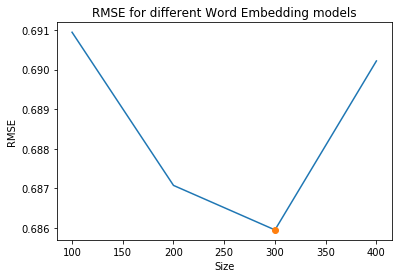

In [44]:
import matplotlib.pyplot as plt

plt.plot(sizes, rmse_word_emb_tune)
plt.xlabel('Size')
plt.ylabel('RMSE')
plt.title('RMSE for different Word Embedding models')
plt.plot([size_min], [rmse_word_emb_min], 'o')
plt.show()

#### Train Model

In [31]:
from gensim.models import Word2Vec 
model = Word2Vec(content_comma_separated, size=size_min)
word2vector = dict(zip(model.wv.index2word, model.wv.vectors))

In [32]:
import collections

# Calculate tfidf vector
tfidf = TfidfVectorizer(analyzer=lambda x: x)
tfidf.fit(content_comma_separated)

# if a word was never seen - it must be at least as infrequent
# as any of the known words - so the default idf is the max of 
# known idf's
max_idf = max(tfidf.idf_)
# Generate word2word matrix
word2word = collections.defaultdict(
    lambda: max_idf,
    [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

# if a text is empty we should return a vector of zeros
# with the same dimensionality as all the other vectors
dim = len(word2vector.items())
# Generate tfidf matrix
tfidf_matrix = np.array([
    np.mean([word2vector[w] * word2word[w]
             for w in words if w in word2vector] or
            [np.zeros(dim)], axis=0)
    for words in content_comma_separated
])

In [33]:
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

#### Make recommendations based on Word Embedding Model

In [34]:
pd.set_option('mode.chained_assignment', None)

nested_recommendations = make_all_recommendations(interactions['user_id'].drop_duplicates().values, similarity_matrix, content_processed, interactions, 5)

100% |########################################################################|


In [35]:
catalog_coverage(nested_recommendations, content_processed.recipe_id.values, 5)

0.23

In [36]:
personalization(nested_recommendations)

0.9988096009219541

#### Make predictions based on Word Embedding Model

In [ ]:
pbar = ProgressBar()

uids = interactions['user_id'].values
rids = interactions['recipe_id'].values

predictions_cos = []
actual_cos = []

#Make a prediction for each interaction in the interactions df
for i in pbar(range(len(interactions))):
    act, pred = get_one_prediction(similarity_matrix, content_processed, interactions, uids[i], rids[i])
    predictions_cos.append(pred)
    actual_cos.append(act)

In [215]:
rmse_cos = mean_squared_error(predictions_cos, actual_cos)**0.5
mae_cos = mean_absolute_error(predictions_cos, actual_cos)
print(f'RMSE: {rmse_cos}, MAE: {mae_cos}')

RMSE: 0.6835017346501558, MAE: 0.43265248779172577


In [216]:
interactions['predicted_rating'] = [item for sublist in predictions_cos for item in sublist]
interactions.head()

,recipe_id,user_id,rating,predicted_rating
0,63986,4470,5.0,4.949731
1,63986,28649,4.0,4.645231
2,63986,37471,5.0,4.879097
3,63986,60992,5.0,4.789671
4,63986,75497,5.0,4.152091


Percent of 5 star rating interactions: 71.03%
Percent of 4 star rating interactions: 25.96%
Percent of 3 star rating interactions: 1.99%
Percent of 2 star rating interactions: 0.58%
Percent of 1 star rating interactions: 0.24%


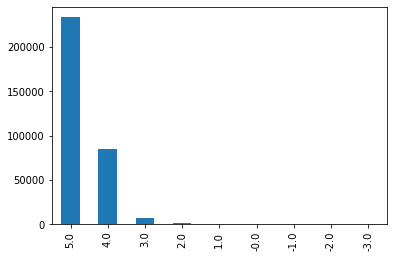

In [217]:
get_rating_dist(round(interactions.predicted_rating))

Recommendation -> =/= already rated -> Coverage
= recommend highest predicted rating NOT seen yet
-> new prediction for ALL recipes for 1 user


<-> Prediction -> RMSE 

<a id='mixture'></a>
### 2.2. Mixture Model

In [41]:
# reset index so recipe id is easily accessible
recipes_data = recipes_data.reset_index()

In [42]:
def get_mix_sim_matrix(processed, lmbda, df_rfiltered):
    cos_sim = get_cos_sim_matrix(processed)
    df_sub = df_rfiltered[['recipe_id', 'n_steps', 'minutes', 'n_ingredients']]
    df_processed = df_sub[df_sub['recipe_id'].isin(processed['recipe_id'])]\
                                                             .set_index('recipe_id')
    scaler = StandardScaler()
    X = scaler.fit_transform(df_processed)
    eucl_dis = euclidean_distances(X,X)
    eucl_sim = 1/np.exp(eucl_dis)
    mixed_sim = np.add(cos_sim*lmbda,eucl_sim*(1-lmbda)) # assume equally weighted
    return mixed_sim

In [43]:
# create similarity matrix of cosine similarity and euclidean distance
# set lambda
lmbda = 0.5
mixed_sim = get_mix_sim_matrix(content_processed, lmbda, recipes_data)
mixed_sim.shape

(11090, 11090)

<a id='mixture-recommendations'></a>
#### 2.2.1. Make recommendations based on Mixture Model

###### Make top k recommendations

In [44]:
# Reset recipe id as index of recipes_data
recipes_data.set_index('recipe_id', inplace=True)

In [45]:
# Make recommendations for the top_k recipes based on user id of the user
# Set number of recipes to receive
k = 5
# Set user_id of user you want to get prediction for
user_id = 60992
get_user_recommendations(user_id, mixed_sim, content_processed, interactions, recipes_data, k)

C:\Users\LiY140\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,name,minutes,submitted,description,prediction,recipeurl,imageurl
recipe_id,,,,,,,
52840,cocoa buttermilk cake,50,2003-01-30,i adopted this recipe 9/06. it is incredible....,4.894781,ht...,"<a href=""https://img.sndimg.com:443/food/image..."
24612,five flavor pound cake,110,2002-04-08,i just tried this cake for the first time at f...,4.894238,ht...,"<a href=""https://img.sndimg.com:443/food/image..."
90203,dark chocolate cake with a raspberry filling,75,2004-04-30,"this is a fudgey, brownie-like cake with a cho...",4.893381,ht...,"<a href=""https://img.sndimg.com:443/food/image..."
113914,hershey s chocolate cake with frosting,70,2005-03-22,"one night i was craving chocolate cake, but we...",4.892404,h...,"<a href=""https://img.sndimg.com:443/food/image..."
49613,the best chocolate cake really,75,2002-12-22,i made this cake for my little brother's 12th ...,4.891674,ht...,"<a href=""https://img.sndimg.com:443/food/image..."


###### Make all recommendations

In [ ]:
pd.set_option('mode.chained_assignment', None)

nested_recommendations_mixture = make_all_recommendations(interactions['user_id'].drop_duplicates().values, 
                                                          mixed_sim, 
                                                          content_processed, 
                                                          interactions, 
                                                          5)

In [ ]:
# Calculcate catalog coverage for mixture model
cc_mixture = catalog_coverage(nested_recommendations_mixture, content_processed.recipe_id.values, 5)
print("The catalog coverage of the mixture model is " + str(cc_mixture))

In [ ]:
# Calculate personalization for mixture model
pers_mixture = personalization(nested_recommendations_mixture)
print("The catalog coverage of the mixture model is " + str(pers_mixture))

<a id='mixture-predictions'></a>
#### 2.2.2. Make predictions based on Mixture Model

In [ ]:
uid_array = interactions['user_id'].values
rids_array = interactions['recipe_id'].values

In [ ]:
predictions_mixed, actual_mixed = make_all_predictions(len(interactions), 
                                                       content_processed, 
                                                       interactions, 
                                                       uid_array, 
                                                       rids_array)

In [ ]:
rmse_mixed = mean_squared_error(predictions_mixed, actual_mixed)**0.5
mae_mixed = mean_absolute_error(predictions_mixed, actual_mixed)
print(f'RMSE: {rmse_mixed}, MAE: {mae_mixed}')

In [ ]:
interactions['predicted_rating_mixed'] = [item for sublist in predictions_mixed for item in sublist]
interactions.head()

In [ ]:
get_rating_dist(round(interactions.predicted_rating_mixed))

<a id='optimize-lambda'></a>
#### 2.2.2. Optimize lambda parameter

In [ ]:
# reset index so recipe id is easily accessible
recipes_data = recipes_data.reset_index()

In [ ]:
def tuning_mix_param(lmbdas, content, interactions, uid_array, rids_array, k):
    rmse_mix = []
    coverage_mix = []
    personalization_mix =[]
    
    for lmbda in lmbdas:
        similarity = get_mix_sim_matrix(content, lmbda, recipes_data)
        
        predictions, actuals = make_all_predictions(len(interactions), similarity, content, interactions, uid_array, rids_array)
        rmse = mean_squared_error(predictions, actuals)**0.5
        rmse_mix.append(rmse)
        
        nested_recommendations = make_all_recommendations(interactions['user_id'].drop_duplicates().values, 
                                                          similarity, 
                                                          content, 
                                                          interactions, 
                                                          k)
        

        coverage = catalog_coverage(nested_recommendations, content.recipe_id.values, k)
        pers = personalization(nested_recommendations)
        
        coverage_mix.append(coverage)
        personalization_mix.append(pers)
           
    return rmse_mix, coverage_mix, personalization_mix

In [ ]:
# Create different values of lambda
lmbdas = np.linspace(0,1,5)

In [ ]:
rmse_mix_tune, coverage_mix_tune, personalization_mix = tuning_mix_param(lmbdas, 
                                                                         content_processed, 
                                                                         interactions, 
                                                                         uid_array,
                                                                         rids_array,
                                                                         5)
rmse_mix_min = min(rmse_mix_tune)
rmse_mix_min_idx = rmse_mix_tune.index(rmse_mix_min)
lmbda_min = lmbdas[rmse_mix_min_idx]

In [ ]:
plt.plot(lmbdas, rmse_mix_tune)
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('RMSE for different mixture models')
plt.plot([lmbda_min], [rmse_mix_min], 'o')
plt.show()

<a id='interpretation_evaluation'></a>
## 3. Interpretation and Evaluation